# Differentiable Physics Model: Lorenz System


In [1]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx

# from jaxsw._src.models.lorenz63 import Lorenz63
# from jaxsw._src.models.lorenz96 import Lorenz96
from jaxsw._src.models.lorenz96 import L96State, Lorenz96, rhs_lorenz_96

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 96


* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\frac{dx}{dt} = (x_{i+1} - x_{i-2})x_{i-1}-x_i+F
$$

where $F$ is normally 8 to cause some chaotic behaviour.

In [2]:
F = 8

In [3]:
# initialize state
ndim = 50
noise = 0.01
state, params = L96State.init_state(ndim=ndim, noise=noise)

# rhs
x = state.x
state_dot = rhs_lorenz_96(x=x, F=F)

x_dot = state_dot

assert x_dot.shape == x.shape

### Model

In [4]:
t0 = 0.0
t1 = 30.0

# initialize state
state, params = L96State.init_state(ndim=ndim, F=F)

# initialize model
l96_model = Lorenz96(tmin=t0, tmax=t1)

# step through
state_dot = l96_model.equation_of_motion(t=0, state=state, args=params)

state_dot.x.shape

(50,)

## Time Stepping

In [5]:
dt = 0.01
t0 = 0.0
t1 = 30.0
# observe_every = 10

saveat = dfx.SaveAt(t0=t0, t1=t1, ts=jnp.arange(t0, t1, t1 - t0))
saveat

SaveAt(
  subs=SubSaveAt(t0=0.0, t1=30.0, ts=f32[1], steps=False, fn=<function save_y>),
  dense=False,
  solver_state=False,
  controller_state=False,
  made_jump=False
)

In [6]:
# initialize state
state, params = L96State.init_state(ndim=ndim, F=F)

# dense observations
# initialize model
l96_model = Lorenz96(tmin=t0, tmax=t1)
out, ts = l96_model.integrate(state, dt=0.01, args=params)

# l96_model
out.x.shape, ts.shape

((3002, 50), (3002,))

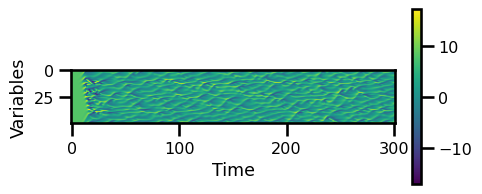

In [7]:
fig, ax = plt.subplots(figsize=(5, 3))

pts = ax.imshow(out.x[::10].T)
fig.colorbar(pts, cmap="viridis", fraction=0.025)
ax.set_xlabel("Time")
ax.set_ylabel("Variables")
plt.tight_layout()
plt.show()

In [8]:
t0 = 0.0
t1 = 30.0

ndim = 50
batchsize = 10

# initialize state
state_batch, params = L96State.init_state_batch(ndim=ndim, batchsize=batchsize, F=F)

In [9]:
# initialize model
l96_model = Lorenz96(tmin=t0, tmax=t1)

# fn = jax.vmap(l96_model.equation_of_motion)

# step through
state_dot = jax.vmap(l96_model.equation_of_motion, in_axes=(None, 0, None))(
    0, state_batch, params
)

state_dot.x.shape

(10, 50)

In [10]:
l96_model = Lorenz96(tmin=t0, tmax=t1)

In [11]:
# initialize model

out, ts = jax.vmap(l96_model.integrate, in_axes=(0, None, None))(
    state_batch, 0.01, params
)

In [12]:
out.x.shape

(10, 3002, 50)

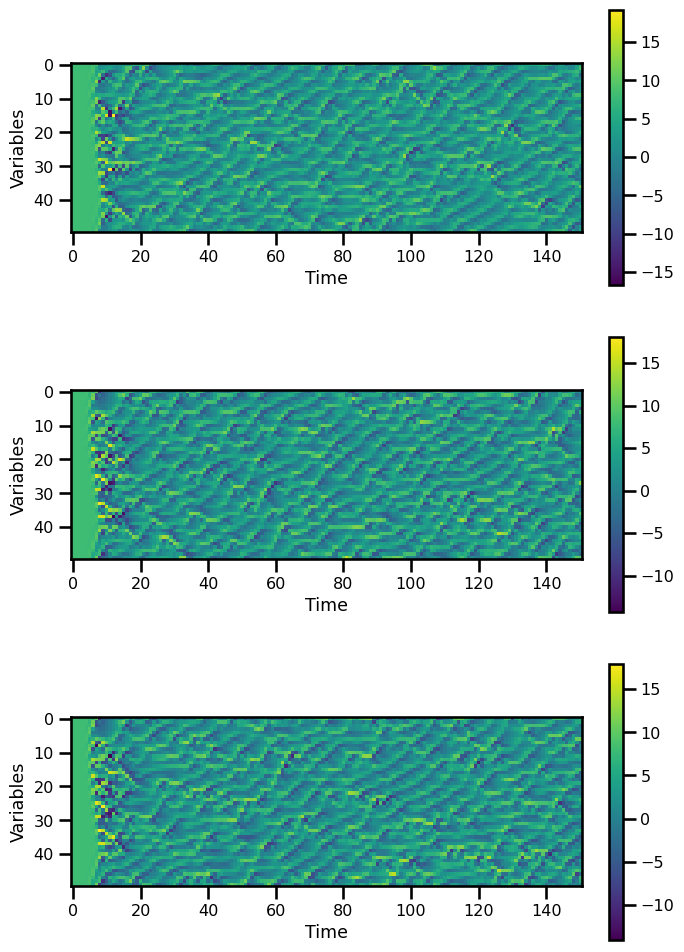

In [13]:
fig, ax = plt.subplots(nrows=3, figsize=(7, 10))

pts = ax[0].imshow(out.x[0][::20].T)
fig.colorbar(pts, cmap="viridis", fraction=0.025)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Variables")

pts = ax[1].imshow(out.x[1][::20].T)
fig.colorbar(pts, cmap="viridis", fraction=0.025)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Variables")

pts = ax[2].imshow(out.x[2][::20].T)
fig.colorbar(pts, cmap="viridis", fraction=0.025)
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Variables")

plt.tight_layout()
plt.show()